# Local registration with ICP

In the RGBD folder we have the first 400 images from one of the datasets from: [http://redwood-data.org/indoor_lidar_rgbd/download.html](http://redwood-data.org/indoor_lidar_rgbd/download.html)

In [7]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import copy
        
# Helper function to draw registrations (reccomended)
def draw_registrations(source, target, transformation = None, recolor = False):
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        if(recolor):
            # source_temp.paint_uniform_color([1, 0.706, 0])
            # target_temp.paint_uniform_color([0, 0.651, 0.929])
            source_temp.paint_uniform_color([1, 0, 0])
            target_temp.paint_uniform_color([0, 0, 0])
        if(transformation is not None):
            source_temp.transform(transformation)
        o3d.visualization.draw_geometries([source_temp, target_temp])

## Creating point clouds from image data
Now we are going to try to create our own point clouds from RGB+depth images.
First, we load two RGBD images.

In [8]:
# Read in images. We have images 000000 - 0000400
color_raw0 = o3d.io.read_image("car_challange/rgb/0000001.jpg")
depth_raw0 = o3d.io.read_image("car_challange/depth/0000001.png")

color_raw1 = o3d.io.read_image("car_challange/rgb/0000005.jpg")
depth_raw1 = o3d.io.read_image("car_challange/depth/0000005.png")

Create point clouds from rgb + depth images.

If you set `convert_rgb_to_intensity = False` you will retain the colors from the rgb image.

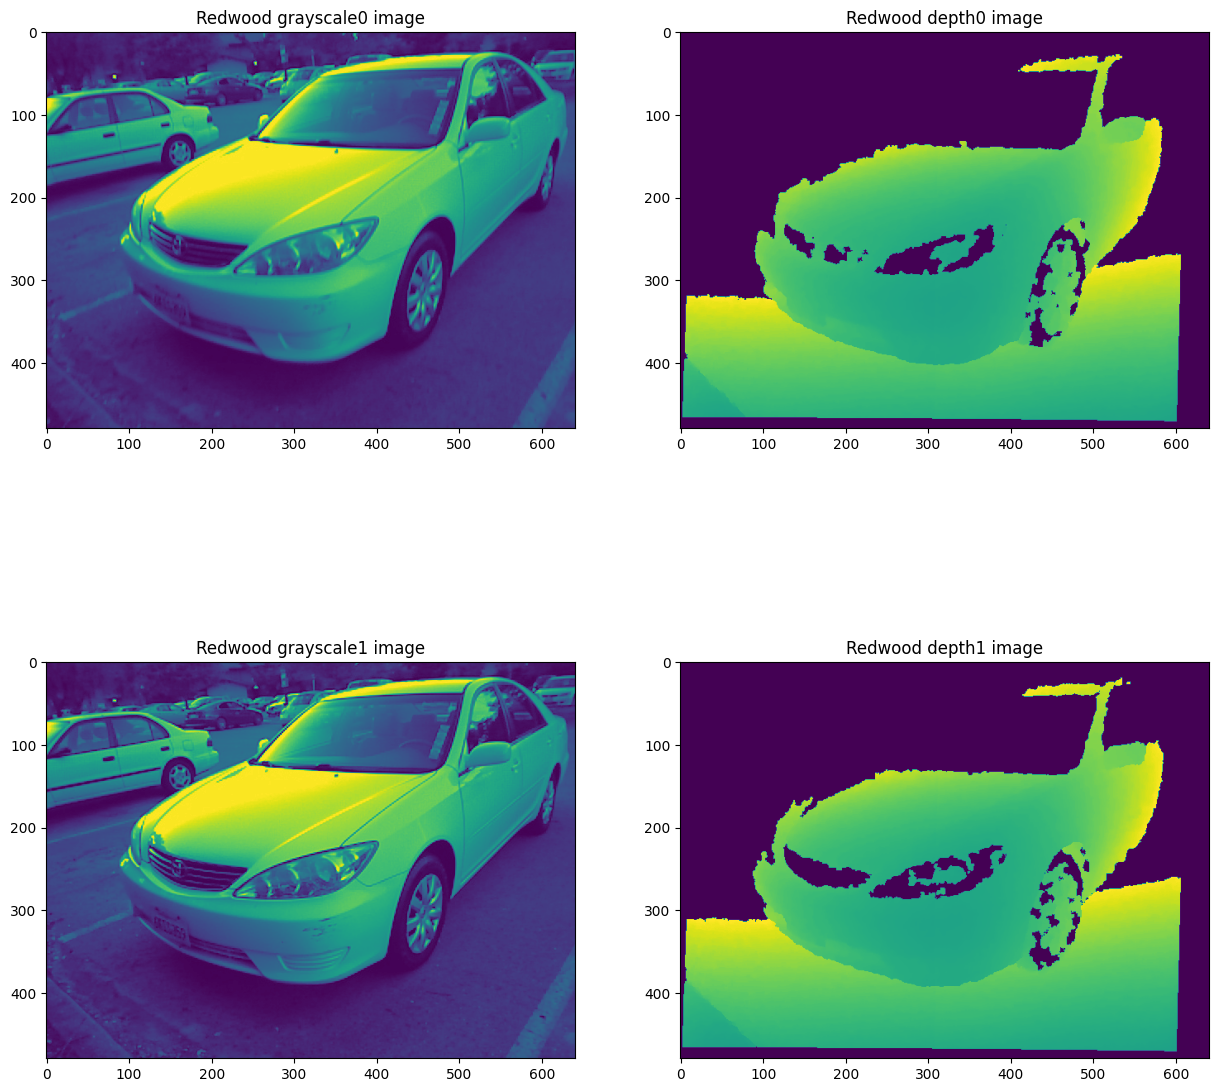

In [9]:
rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw0, 
    depth_raw0, 
    convert_rgb_to_intensity = True)

rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw1, 
    depth_raw1, 
    convert_rgb_to_intensity = True)

# #show images
fig= plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Redwood grayscale0 image')
plt.imshow(rgbd_image0.color)

plt.subplot(222)
plt.title('Redwood depth0 image')
plt.imshow(rgbd_image0.depth)

plt.subplot(223)
plt.title('Redwood grayscale1 image')
plt.imshow(rgbd_image1.color)

plt.subplot(224)
plt.title('Redwood depth1 image')
plt.imshow(rgbd_image1.depth)

plt.show()


## Images to point cloud
Now we create point clouds from the RGBD images we just loaded/created.


Here, we use `PinholeCameraIntrinsicParameters.PrimeSenseDefault` as default camera parameters. 

It has an image resolution of 640x480, focal length of ($f_x$, $f_y$) = (525.0, 525.0), and optical center ($c_x$, $c_y$) = (319.5, 239.5). 

An identity matrix is used as default extrinsic parameters. `pcd.transform` applies an up-down flip transformation on the point cloud for an improved visualization.


If execution becomes too slow you can downsample the point cloud.

In [10]:
# Source pointcloud
camera = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Target pointcloud
target = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image1, camera)

# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# Draw
draw_registrations(source, target, recolor=True)


### Evaluation of pointclouds

Before we can run ICP, we evaluate our source and target point clouds. This gives us a feeling if we need a better initial transformation or not.
From (http://www.open3d.org/docs/latest/tutorial/Basic/icp_registration.html):

"The function `evaluate_registration` calculates two main metrics. 
- `fitness` measures the overlapping area (# of inlier correspondences / # of points in target). The higher the better. 
- `inlier_rmse` measures the RMSE of all inlier correspondences. The lower the better.

In [11]:
# Parameters
threshold = 0.02
trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

#Evaluate registration
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=4.492835e-01, inlier_rmse=1.156006e-02, and correspondence_set size of 74679
Access transformation to get result.


## ICP

Now try to call icp with your point clouds and your initial transformation.

Initially we use:
```Python
point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()
icp_result = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)
```

In [12]:
###
# ICP code here
###
# source_normals = source.estimate_normals()
target_normals = target.estimate_normals()

point_to_plane = o3d.pipelines.registration.TransformationEstimationPointToPlane()
icp_result = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)

# icp_result = o3d.pipelines.registration.registration_icp()

draw_registrations(source, target, icp_result.transformation, True)
draw_registrations(source, target, icp_result.transformation)

In [13]:
print("First ICP alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold, icp_result.transformation)
print(evaluation)

First ICP alignment
RegistrationResult with fitness=9.876367e-01, inlier_rmse=5.442312e-03, and correspondence_set size of 164163
Access transformation to get result.


In [14]:
print(icp_result.transformation)

[[ 9.99995649e-01  2.92918073e-03  3.49017590e-04  1.60215599e-03]
 [-2.92789626e-03  9.99989141e-01 -3.62560839e-03  2.66410723e-02]
 [-3.59633862e-04  3.62457072e-03  9.99993367e-01  9.95474905e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


# Exersices

### A)
If you increase the amount of steps from the original image so from i.e. 000000.jpg<>000005.jpg to 00000.jpg<>000300.jpg, what happens?


In [15]:
color_raw300 = o3d.io.read_image("RGBD/color/000300.jpg")
depth_raw300 = o3d.io.read_image("RGBD/depth/000300.png")

[Open3D WARNING] Read JPG failed: unable to open file: RGBD/color/000300.jpg
[Open3D WARNING] Read PNG failed: unable to parse header.


In [16]:
rgbd_image300 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw300, 
    depth_raw300, 
    convert_rgb_to_intensity = True)

In [17]:
target_300 = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image300, camera)

RuntimeError: [1;31m[Open3D Error] (static std::shared_ptr<open3d::geometry::PointCloud> open3d::geometry::PointCloud::CreateFromRGBDImage(const open3d::geometry::RGBDImage&, const open3d::camera::PinholeCameraIntrinsic&, const Matrix4d&, bool)) /root/Open3D/cpp/open3d/geometry/PointCloudFactory.cpp:176: Unsupported image format.
[0;m

In [102]:
threshold = 0.05
trans_init = np.asarray([[1, 0, 0, 0], 
                         [0, 1, 0, 0], 
                         [0, 0, 1, 2], 
                         [0, 0, 0, 1]])

In [103]:
point_to_plane = o3d.pipelines.registration.TransformationEstimationPointToPlane()

target_300_normals = target_300.estimate_normals()

icp_result_300 = o3d.pipelines.registration.registration_icp(
    source, target_300, threshold, trans_init,
    point_to_plane)

In [104]:
icp_result_300

RegistrationResult with fitness=9.310637e-02, inlier_rmse=2.073345e-02, and correspondence_set size of 24357
Access transformation to get result.

In [105]:
icp_result_300

RegistrationResult with fitness=9.310637e-02, inlier_rmse=2.073345e-02, and correspondence_set size of 24357
Access transformation to get result.

In [106]:
icp_result_300

RegistrationResult with fitness=9.310637e-02, inlier_rmse=2.073345e-02, and correspondence_set size of 24357
Access transformation to get result.

In [107]:
draw_registrations(source, target_300, icp_result_300.transformation, True)

### B)
Can you tweak the parameters `threshold` and `trans_init` to combat some of the ill effects that starts appearing?


### C)
Again try to use 
```Python
point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)
```

This requires you to find the normals for each point cloud use:
```python
    source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                            max_nn=30),fast_normal_computation=True)
```
Compare the resulting translations of the two methods. Is one better than the other?


In [108]:
point_to_plane = o3d.pipelines.registration.TransformationEstimationPointToPlane()

reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target_300, threshold, trans_init,
    point_to_plane)

source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                        max_nn=30), fast_normal_computation=True)

In [109]:
reg_p2p

RegistrationResult with fitness=9.310637e-02, inlier_rmse=2.073345e-02, and correspondence_set size of 24357
Access transformation to get result.

### D)
Extend this and try to see how much of the bedroom you can reconstruct from the RGB and depth images.
You can extend a point cloud by `new = source + target`. Remember to resample the point cloud after a view additions so it does not get too large: `down_source = source.voxel_down_sample(voxel_size=0.05)`